# Elastic FWI on Marmousi II using CGG data setup


by Oleg Ovcharenko

oleg.ovcharenko@kaust.edu.sa

KAUST, 2021

In [2]:
import os
import sys
import copy
import glob
import numpy as np
import importlib
import multiprocessing
import scipy
import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize
# MAKE SURE THIS POINTS TO WHRE DENISE IS
# sys.path.append(os.path.abspath('../'))

sys.path.append(os.path.abspath('../codes_server'))
from F_utils import *
from F_fwi import *
# import pyapi_denise_pavel as api
import pyapi_denise as api

print(f'Python: {sys.prefix}')
api._cmd(('source /home/plotnips/Madagascar/share/madagascar/etc/env.sh'))
import shared as sd
import loaders as ld
import vis
from IPython.display import clear_output
import m8r as sf
print(sf)
# # This is to prevent error "this loop already runnign when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

Python: /home/plotnips/anaconda3/envs/torch2
source /home/plotnips/Madagascar/share/madagascar/etc/env.sh


In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

### Where to save outputs

In [6]:
simulation_root='./out_for_pasha_marm'
simulation_root='./out_for_pasha_marm_high_freqs_test'
root_fwi=os.path.join(simulation_root,'fld')
# sbatch_file_name=simulation_root.split('/')[-1]+'.sh'
# print(sbatch_file_name)
# create_sbatch_file_for_fwi_folder(sbatch_file_name,simulation_root)

# Init Denise API

In [7]:
importlib.reload(api)
print(os)
# denise_root = '../den/'
denise_root = '../'
d = api.Denise(denise_root, verbose=1)
# d.parser_report()

<module 'os' from '/home/plotnips/anaconda3/envs/torch2/lib/python3.9/os.py'>
Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise
Parse ../par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/


## Work directory
Where to output everything

In [8]:
d.save_folder = root_fwi
print(d.save_folder)
d.set_paths()
print(d.save_folder)

./out_for_pasha_marm_high_freqs_test/fld
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./out_for_pasha_marm_high_freqs_test/fld
./out_for_pasha_marm_high_freqs_test/fld


# Get acquitision details

In [9]:
shot_id_min = 60
n_selected_shots = 80
njump_src = 8
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src

In [10]:
%run ./fwi_shared_check.ipynb

80/80
Before prep:	(80, 648, 3526)
Data cube:	(80, 324, 3000)
Extended cube:	(80, 324, 3100)
[80, 324, 3050] (80, 324, 3000)
[80, 324, 3150] (80, 324, 3100)
25.0
Assume even average spacing between sources
 150.0 m ~ 6 grid nodes
First source:	1125.0 m
Last source:	12950.0 m
150.0
name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets:	None
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [13]:
print('Field data spacing between sources {:.2f} m'.format(np.mean(src_.x[1:] - src_.x[:-1])))
print(dx)
extend

Field data spacing between sources 149.75 m
25.0


<function __main__.extend(x, ez, ex)>

In [9]:
vp_baseline = vp.copy()
print(vp.shape)
marm_path = os.path.join(root_fwi, 'start/')
os.makedirs(marm_path, exist_ok=True)
print(marm_path)
if not 'marmousi_II_marine.vp' in os.listdir(marm_path):
    # Download Marmousi II model
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.rho -P {marm_path}')

    # Download initial model for FWI
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.rho -P {marm_path}')
def get_vp_vs_rho(vp):
    vp = extend(vp, 15, 0)

    print(f'Reshape {vp.shape} into {wb_taper.shape}...')

    vp = resize(vp, wb_taper.shape, anti_aliasing=True)
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    vp = extend(vp, 0, 264 + 10 * 8)

    # shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)

    # density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    return vp, vs, rho
def get_vp_vs_rho_no_extend(vp):
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    # shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)
    # density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    return vp, vs, rho
def copy_su_from_to(path_from, path_to):
    """ Copy files matching *.su.* from one folder to another folder"""
    os.makedirs(path_to, exist_ok=True)
    su_files = glob.glob(path_from + '/*.su.*')
    su_files = [f for f in su_files if '.it' not in f]
    print(f'Found {len(su_files)} *.su.* files in {path_from}')

    commands = []
    print(f'Copy files from {path_from} to {path_to}')
    for f in su_files:
        commands.append(f'cp {f} {path_to}')
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

(152, 600)
./out_for_pasha_marm_high_freqs/fld/start/


# REPLACE MODEL BY MARMOUSI TO GENERATE "FIELD" DATA

In [10]:
vp_orig = load_bin(f'{marm_path}marmousi_II_marine.vp', (500, 174))
vs_orig = load_bin(f'{marm_path}marmousi_II_marine.vs', (500, 174))
rho_orig = load_bin(f'{marm_path}marmousi_II_marine.rho', (500, 174))
model_orig = api.Model(vp_orig,vs_orig,rho_orig, dx)
nx0 = 500
limits_vp = {'vmin': model_orig.vp.min() / 1000, 'vmax': model_orig.vp.max() / 1000}
limits_vs = {'vmin': model_orig.vs.min() / 1000, 'vmax': model_orig.vs.max() / 1000}
limits_rho = {'vmin': model_orig.rho.min() / 1000, 'vmax': model_orig.rho.max() / 1000}
print(vp_orig[-30:,33])
# vis.plot_log_model(model_orig.vp, dx, nx0, nz0, src, **limits_vp)
# vis.plot_log_model(model_orig.vs, dx, nx0, nz0, src, **limits_vs)
# vis.plot_log_model(model_orig.rho, dx, nx0, nz0, src, **limits_rho)
# vp2,vs2,rho2 = get_vp_vs_rho_no_extend(model_orig.vp)
# print(model_orig.vp)
# print(vp2)

# vis.plot_log_model(model_orig.vp-vp2, dx, nx0, nz0, src)
# vis.plot_log_model(model_orig.vs-vs2, dx, nx0, nz0, src)
# vis.plot_log_model(model_orig.rho-rho2, dx, nx0, nz0, src)


(174, 500)
(174, 500)
(174, 500)
[2178.8213 2172.6975 2166.5737 2160.45   2006.9462 1949.7916 1876.3092
 1837.1172 1500.     1500.     1500.     1500.     1500.     1500.
 1500.     1500.     1500.     1500.     1500.     1500.     1500.
 1500.     1500.     1500.     1500.     1500.     1500.     1500.
 1500.     1500.    ]


In [11]:
vp_marm = load_bin(f'{marm_path}marmousi_II_marine.vp', (500, 174))[:, 100:]
print(vp_marm.min(), vp_marm.max())
print('vp_marm.shape=',vp_marm.shape)
############################### rescale marmousi velocity range
# # This is what was used in generation of training data
# box_min = 1490.
# box_max = 4000. 

# vmin_marm = vp_marm.min()
# vp_marm -= vmin_marm

# vmax_marm = vp_marm.max()
# vp_marm /= vmax_marm
# vp_marm = box_min  + vp_marm * (box_max - box_min)
# print(vp_marm.min(), vp_marm.max())
############################### not rescale marmousi velocity range
vp_marm=vp_marm
print(vp_marm.min(), vp_marm.max())
print('vp_marm2.shape=',vp_marm.shape)
vmin_marm = vp_marm.min()
vmax_marm = vp_marm.max()
box_min = vmin_marm
box_max = vmax_marm

(174, 500)
1500.0 4766.604
vp_marm.shape= (174, 400)
1500.0 4766.604
vp_marm2.shape= (174, 400)


Reshape (189, 400) into (152, 600)...
vp:	(152, 944), 1490.0000, 4766.6040 m/s

vs:	(152, 944), 0.0000, 2752.0001 m/s

rho:	(152, 944), 1000.0000, 2492.7201 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


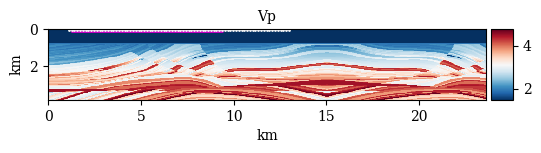

In [12]:
vp, vs, rho = get_vp_vs_rho(vp_marm)
vis.plot_acquisition(vp, dx, src, rec, title='Vp')
model = api.Model(vp, vs, rho, dx)
print(model)

## Model prepared by Daniel Kohn from Kiel University

(174, 500)
Reshape (189, 400) into (152, 600)...
vp_linear.shape= (152, 944)
vp:	(152, 944), 1490.0000, 4766.6040 m/s

vs:	(152, 944), 0.0000, 2752.0001 m/s

rho:	(152, 944), 1000.0000, 2492.7201 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


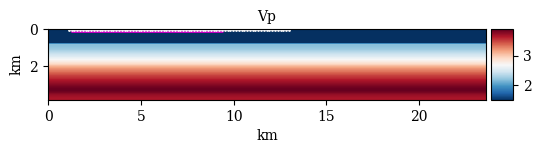

In [13]:
vp_marm_linear = load_bin(f'{marm_path}marmousi_II_start_1D.vp', (500, 174))[:, 100:]
# vp_marm_linear -= vmin_marm
# vp_marm_linear /= vmax_marm
# vp_marm_linear = box_min  + vp_marm_linear * (box_max - box_min)

vp_linear, vs_linear, rho_linear = get_vp_vs_rho(vp_marm_linear)
vis.plot_acquisition(vp_linear, dx, src, rec, title='Vp')
model_linear = api.Model(vp_linear, vs_linear, rho_linear, dx)
print('vp_linear.shape=',vp_linear.shape)
log_linear = vp_linear[:, log_idx]
print(model)

## Acquisition design

vp:	(152, 944), 1490.0000, 4766.6040 m/s

vs:	(152, 944), 0.0000, 2752.0001 m/s

rho:	(152, 944), 1000.0000, 2492.7201 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


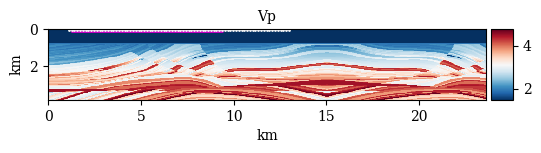

In [14]:
# Set custom wavelet
wls = bpw[:, ::2]
src.wavelets = wls[:, :limit_nt]

vis.plot_acquisition(vp, dx, src, rec, title='Vp')
print(model)

Save /home/plotnips/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/vinit.png


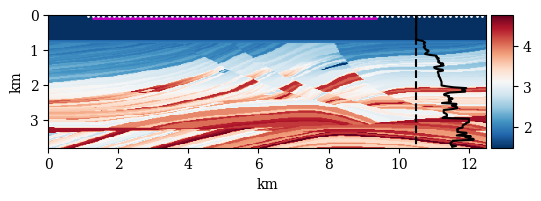

In [15]:
log = model.vp[:, log_idx]
# model_log = copy.deepcopy(model)

log_dict = {'data':log/2, 'loc': log_loc}
vis.plot_acquisition(vp[:, :500], dx, src, rec, log=log_dict)
vis.savefig('vinit.png')

Text(0.5, 0, 'Depth, km')

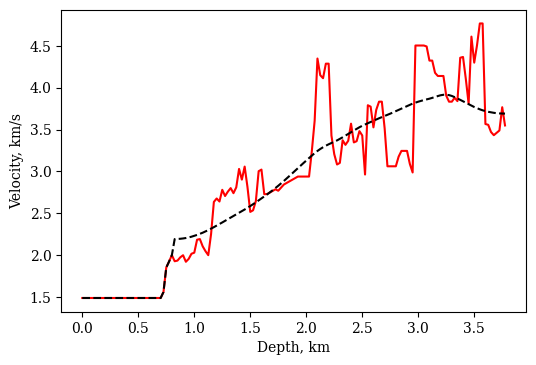

In [16]:
fig, ax = plt.subplots(1,1); 
# ax_depth = np.arange(len(wlog)) * dx / 1000
ax_depth = np.arange(len(log)) * dx / 1000
# ax.plot(ax_depth, wlog[::-1] / 1000, 'b', label='CGG')
ax.plot(ax_depth, log[::-1] / 1000, 'r', label='Well')
ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Init')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')

In [17]:
print(src, end='\n\n------------\n')
print(rec)

name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets	(80, 3000):	min: -5.2003522040678645	max: 6.286853676317875
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0

------------
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


## Generate true waveforms

Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [18]:
# Elastic modeling
d.verbose = 1
d.PHYSICS = 1
d.SEISMO = 2
d.DT = dDT
d.NT = data_p.shape[-1]
d.TIME = dDT * d.NT
#
d.FC_SPIKE_2 = 10
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)

# d.TESTSHOT_START = np.round(0.1 * len(src))
# d.TESTSHOT_END = np.round(0.9 * len(src))
# d.TESTSHOT_INCR = 5

d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10

d.QUELLTYPB = 4
d.QUELLART = 3  

d.WRITE_STF = 0

# Acoustic case 
# d.PHYSICS = 2
# src.wavelets = -wls[:, :limit_nt]
print(d.DT, d.NT)

0.002 3000


### Run forward modeling

In [19]:
d.NPROCX = 1
d.NPROCY = 1
par_forward = {'run_command': 'mpirun -np 35', 'disable': True}
# par_forward = {'run_command': 'mpirun -np 35', 'disable': False}

In [20]:
# if par_forward['disable']==True:
#     print(d._root_su)
#     copy_su_from_to('./out_for_pasha_wavefield/su/',d._root_su)
d.forward(model, src, rec, **par_forward)

Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./out_for_pasha_marm_high_freqs/fld
Init model:
	152 x 944, dx = 25.0 m
Check max source frequency:
	min Vs: 881.000003527578 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.550135539594342 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 944 % 1 = 0
	in Y-direction, NY % NPROCY, 152 % 1 = 0
Write ./out_for_pasha_marm_high_freqs/fld/start/model.vp
Write ./out_for_pasha_marm_high_freqs/fld/start/model.vs
Write ./out_for_pasha_marm_high_freqs/fld/start/model.rho
Enable streamer mode!
	source 1: ./out_for_pasha_marm_high_freqs/fld/receiver/receivers_shot_1
	source 2: ./out_for_pasha_marm_high_freqs/fld/receiver/receivers_shot_2
	source 3: ./out_for_pasha_marm_high_freqs/fld/receiver/receivers_shot_3
	source 4: ./out_for_pasha_marm_high_freqs/fld/receiver/receivers_shot_4
	

80
Read 80 shots (324, 3000) into list


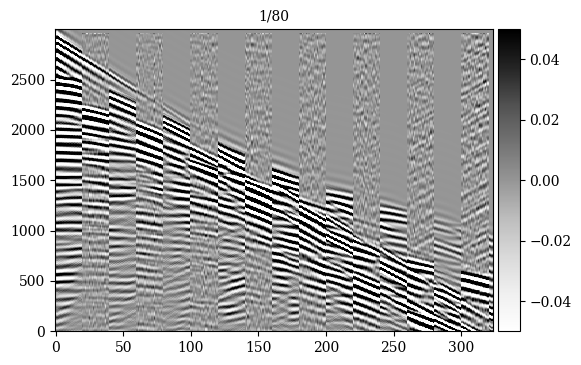

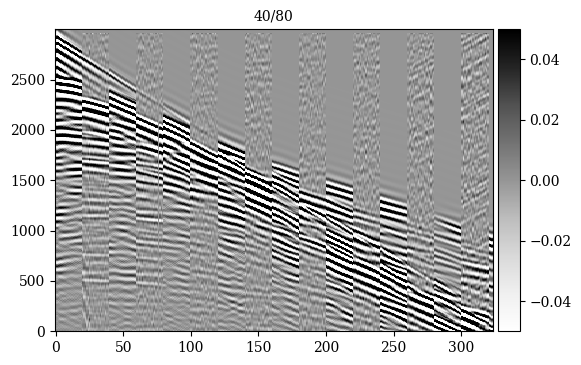

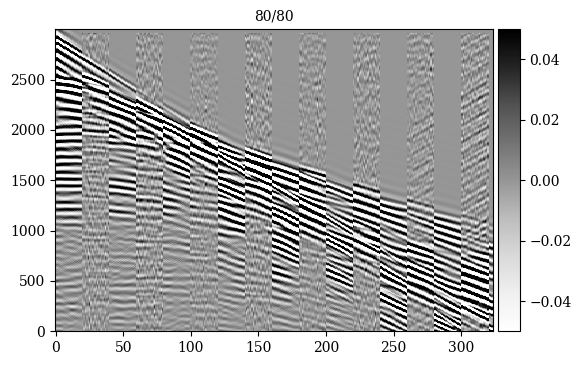

In [21]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p.'])
print(len(shots))

par_shot = {'vmin': -0.05, 'vmax': 0.05}
if shots:
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    for i in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 3)]:
        try:
            shot_s = divmax(shots[i])
            shot_f = divmax(data_p[i, :, ::d.NDT])
            vis.plot_compare_stripes(shot_s, shot_f, title=f'{i+1}/{len(shots)}', **par_shot)
        except:
            print(f'Failed to fetch data for i={i}')

# Compare syn and field

8325.0
80
Total sources: 80
Syn wavelets:	(80, 500)	-260.77	281.46
Field wavelets:	(80, 500)	-189.35	281.46
[0, 8, 17, 26, 35, 43, 52, 61, 70, 79]


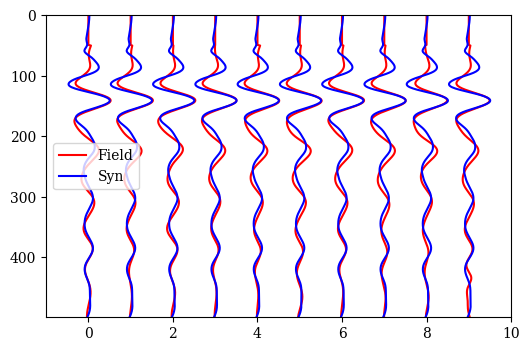

In [22]:
print(src.x[48])
wavelets_s = []
wavelets_f = []
print(len(shots))
for i, shot in enumerate(shots):
    no, nt = 1, 500
    wavelets_s.append(shot[:no, :nt].copy())
    wavelets_f.append(data_p[i, :no, :nt:d.NDT].copy())
print(f'Total sources: {len(wavelets_f)}')
wavelets_s = np.concatenate(wavelets_s, 0)
wavelets_f = np.concatenate(wavelets_f, 0)

# !!! DO THIS IN FIELD DATA APPLICATION !!!
# THIS MAKES SYNTHETIC AND FIELD COMPARABLE
# OTHERWISE THERE IS INSANE AMPLITUDE MISMATCH
wavelets_f /= np.max(wavelets_f)
wavelets_f *= wavelets_s.max()

print('Syn wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_s.shape, wavelets_s.min(), wavelets_s.max()))
print('Field wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_f.shape, wavelets_f.min(), wavelets_f.max()))

vis.plot_wiggles([wavelets_f, wavelets_s], n=10, colors=['r', 'b'], legend=['Field', 'Syn'])

Save /home/plotnips/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/wavelet_syn_field.png


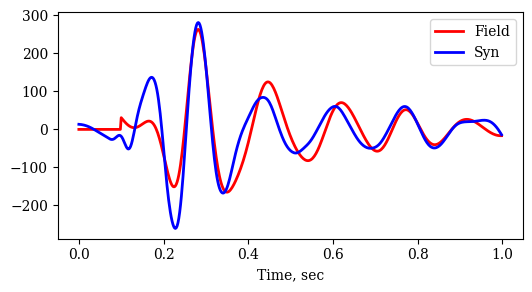

In [23]:
if shots:
    tvec = np.arange(nt) * d.DT
    plt.figure(figsize=(6,3)); 
    trace_idx = 0
    plt.plot(tvec, wavelets_f[trace_idx,:], 'r', lw=2, label='Field')
    plt.plot(tvec, wavelets_s[trace_idx,:], 'b', lw=2, label='Syn')
    # plt.plot(tvec, _dplotted[0][0], 'r', lw=2, label='Field')
    # plt.plot(tvec, _dplotted[1][0], 'b', lw=2, label='Syn')
    plt.legend()
    plt.xlabel('Time, sec')
    vis.savefig('wavelet_syn_field.png')

# REPLACE FIELD DATA BY MARM DATA

In [24]:
data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
print(data_p.shape)
data_p_backup = data_p.copy()
print(data_p_backup.shape, d.DT)

(80, 324, 3000)
(80, 324, 3000) 0.002


(80, 324, 3000) -272.93542 281.45642


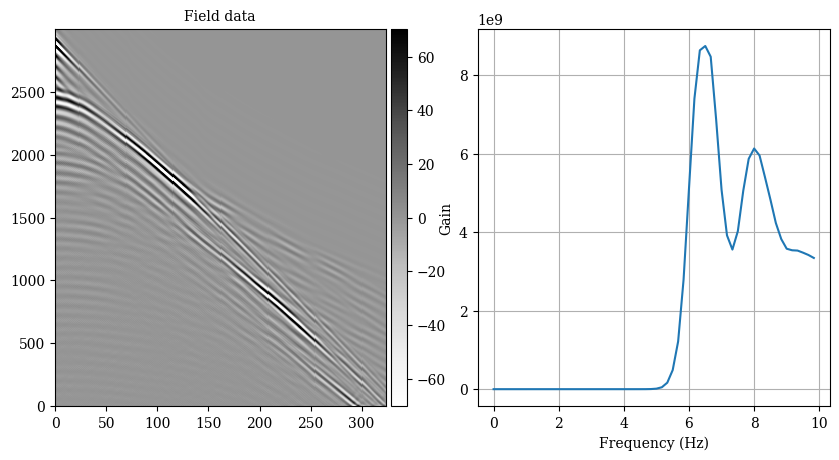

In [25]:
# data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
print(data_p.shape, data_p.min(), data_p.max())
dref = np.mean(data_p, 0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vis.plot_shot(dref, title='Field data', pclip=0.25, colorbar=True, ax=ax[0])
vis.plot_spectrum(dref, dt=0.002, fmax=10, title='Spectrum', ax=ax[1])

## Save field data to a new folder in /su/
## Delete frequencies below 5 hz

In [26]:
root_su_field = os.path.join(d._root_su, 'field/')
api._cmd('rm -r '+root_su_field)
copy_su_from_to(d._root_su, root_su_field)
# api._cmd('rm -f '+os.path.join(d._root_su,'*.su.*'))
denise_folder_process('crop_zero_freqs',simulation_root,denise_root=denise_root)

rm -r ./out_for_pasha_marm_high_freqs/fld/su/field/
Found 80 *.su.* files in ./out_for_pasha_marm_high_freqs/fld/su
Copy files from ./out_for_pasha_marm_high_freqs/fld/su to ./out_for_pasha_marm_high_freqs/fld/su/field/
processing ./out_for_pasha_marm_high_freqs
Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise
os.getcwd()= /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
low frequency data corner frequency,  5
Read 80 shots (324, 3000) into list
save to ./out_for_pasha_marm_high_freqs/pictures/shot_0.png
save to ./out_for_pasha_marm_high_freqs/pictures/shot0_stage2.png
pic saved to  ./out_for_pasha_marm_high_freqs/pictures/spectrum_0_original.png
pic saved to  ./out_for_pasha_marm_high_freqs/pictures/spectrum_0stage2.png
save to ./out_for_pasha_marm_high_freqs/pictures/shot_22.png
save to ./out_for_pasha_marm_high_freqs/pictures/shot22_stage2.png
pic saved to  ./out_for_pasha_marm_high_freqs/pictures/spectrum_22_original.pn

In [27]:
def get_fnames_pattern(pattern):    
    fnames = natsorted(glob.glob(pattern))
    fnames = [f for f in fnames if '.it' not in f]
    print(f'{len(fnames)} files found in {pattern}')
    return fnames
fnames = get_fnames_pattern(root_su_field + '*.su.*')

80 files found in ./out_for_pasha_marm_high_freqs/fld/su/field/*.su.*


In [28]:
wb_taper = np.where(model.vp < 1.01 * model.vp.min(), 1, 0)
nx0 = 500
limits_vp = {'vmin': model.vp.min() / 1000, 'vmax': model.vp.max() / 1000}
limits_vs = {'vmin': model.vs.min() / 1000, 'vmax': model.vs.max() / 1000}
limits_rho = {'vmin': model.rho.min() / 1000, 'vmax': model.rho.max() / 1000}

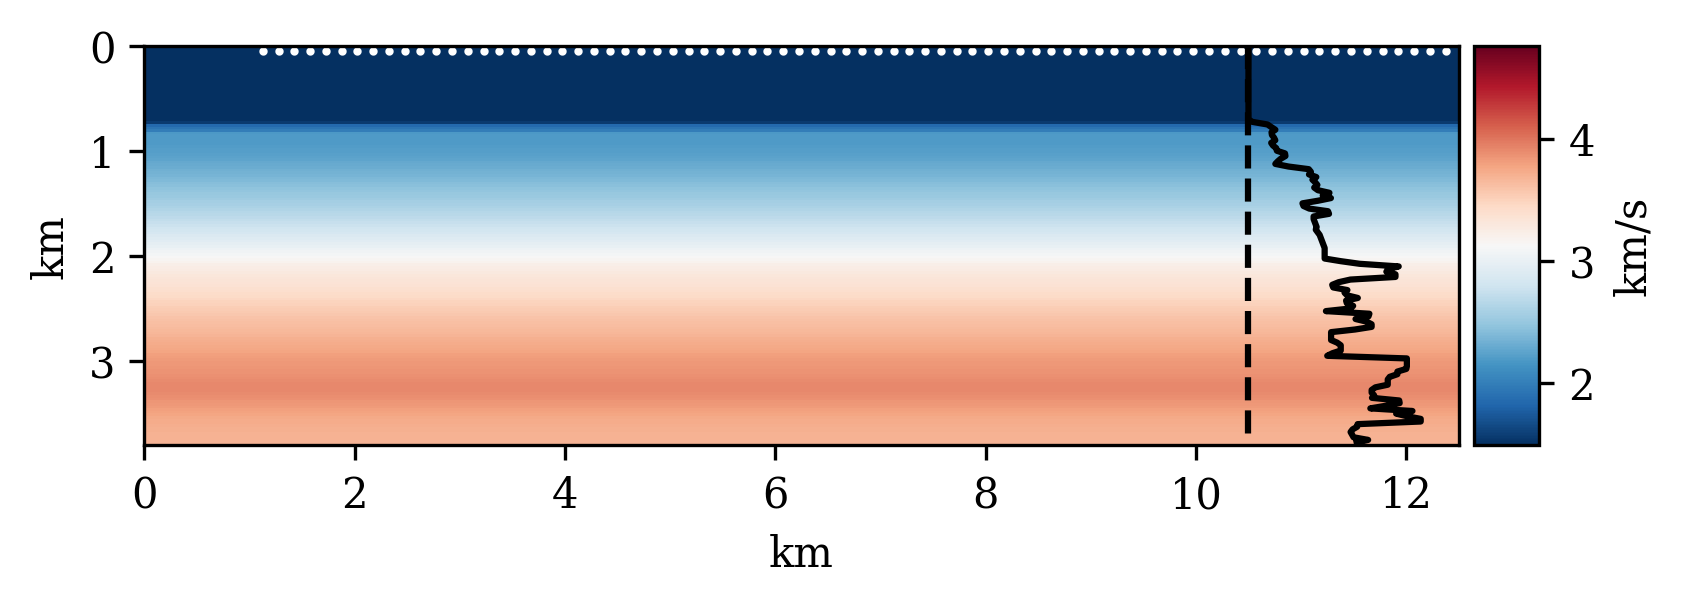

In [29]:
mpl.rcParams['figure.dpi']= 300
vis.plot_log_model(vp_linear, dx, nx0, nz0, src, log=log / 2, log_location=log_location, **limits_vp)
mpl.rcParams['figure.dpi']= 100

## Crop predicted model
Large part of the model (beyond last source) was only to get full-offset seismic data. When running inversion it is not needed so we cut it down

vp:	(152, 944), 1490.0000, 3915.7598 m/s

vs:	(152, 944), 0.0000, 2260.7650 m/s

rho:	(152, 944), 1000.0000, 2373.1504 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m
(116, 1) (152, 944)


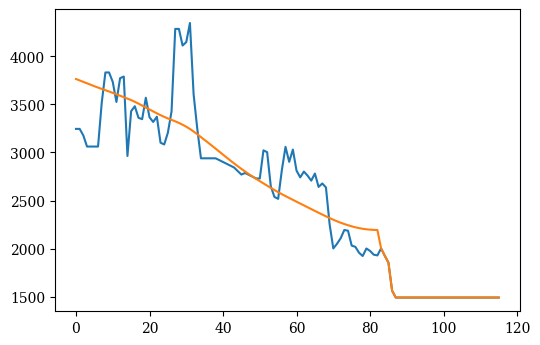

In [30]:
model_init = copy.copy(model_linear)
print(model_init)
print(wlog.shape, vp.shape)
fig, ax = plt.subplots(1,1)
ax.plot(vp[-len(wlog):, log_idx])
ax.plot(model_init.vp[-len(wlog):, log_idx])

# Full-waveform inversion
Invert for elastic properties `vp`, `vs` and `rho`, given `x` and `y` velocity components of wavefield 

## Initial velocity model
Smooth background model with true water bottom and shallow sediments

116 (152, 944) 116


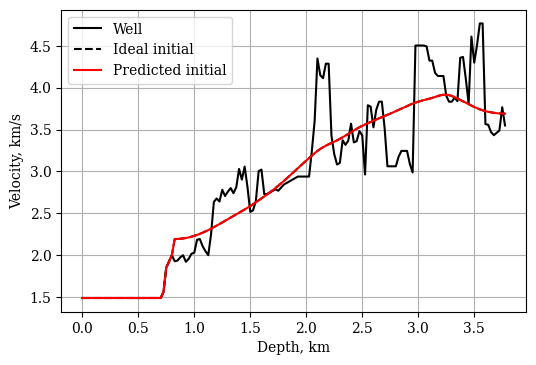

In [31]:
# ax = plot_model(np.concatenate((model_init.vp, model_init.vs, model_init.rho), 1))
# plot_logs(model_log, model_init, log_idx)

fig, ax = plt.subplots(1,1); 
# ax_depth = np.arange(len(wlog)) * dx / 1000
ax_depth = np.arange(len(log_linear)) * dx / 1000
ax.plot(ax_depth, log[::-1] / 1000, 'k', label='Well')
ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Ideal initial')

# log_pred = model_init.vp[-len(wlog):, log_idx]

log_pred = model_init.vp[-len(log):, log_idx]
ax.plot(ax_depth, log_pred[::-1] / 1000, 'r', label='Predicted initial')

nwater = 33#33
dummy = np.zeros_like(model.vp)
dummy[-nwater:, :] = 1.
log_taper = np.min(log_pred) + dummy[:, log_idx] * (np.max(log_pred) - np.min(log_pred))
log_taper = np.min(log_pred) + wb_taper[-len(wlog):, log_idx] * (np.max(log_pred) - np.min(log_pred))
# ax.plot(ax_depth, log_taper[::-1]  / 1000, 'b', label='Taper')
# 
# ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Linear')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

print(len(wlog), model_init.vp.shape, len(model_init.vp[:len(wlog)]))

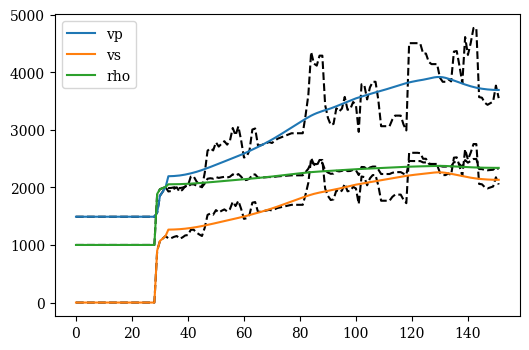

In [32]:
plot_logs(model, model_init, log_idx)

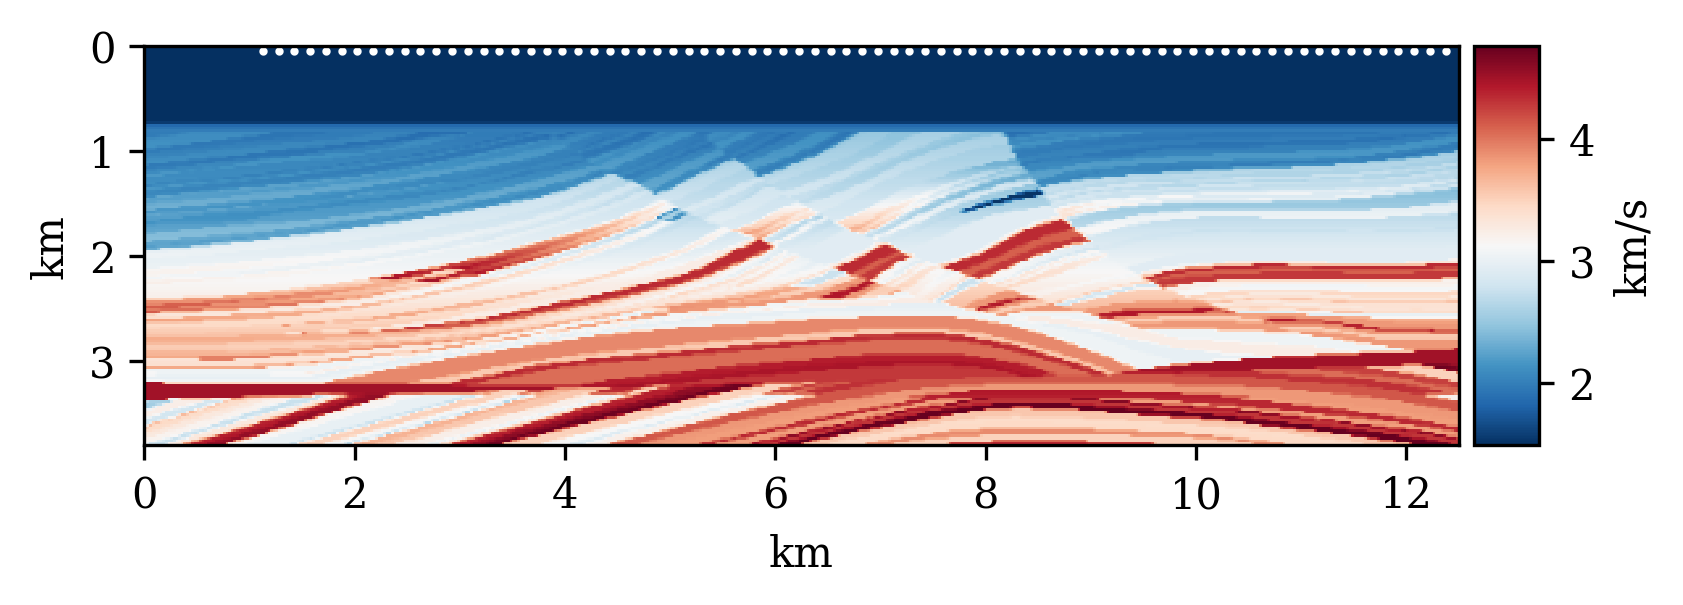

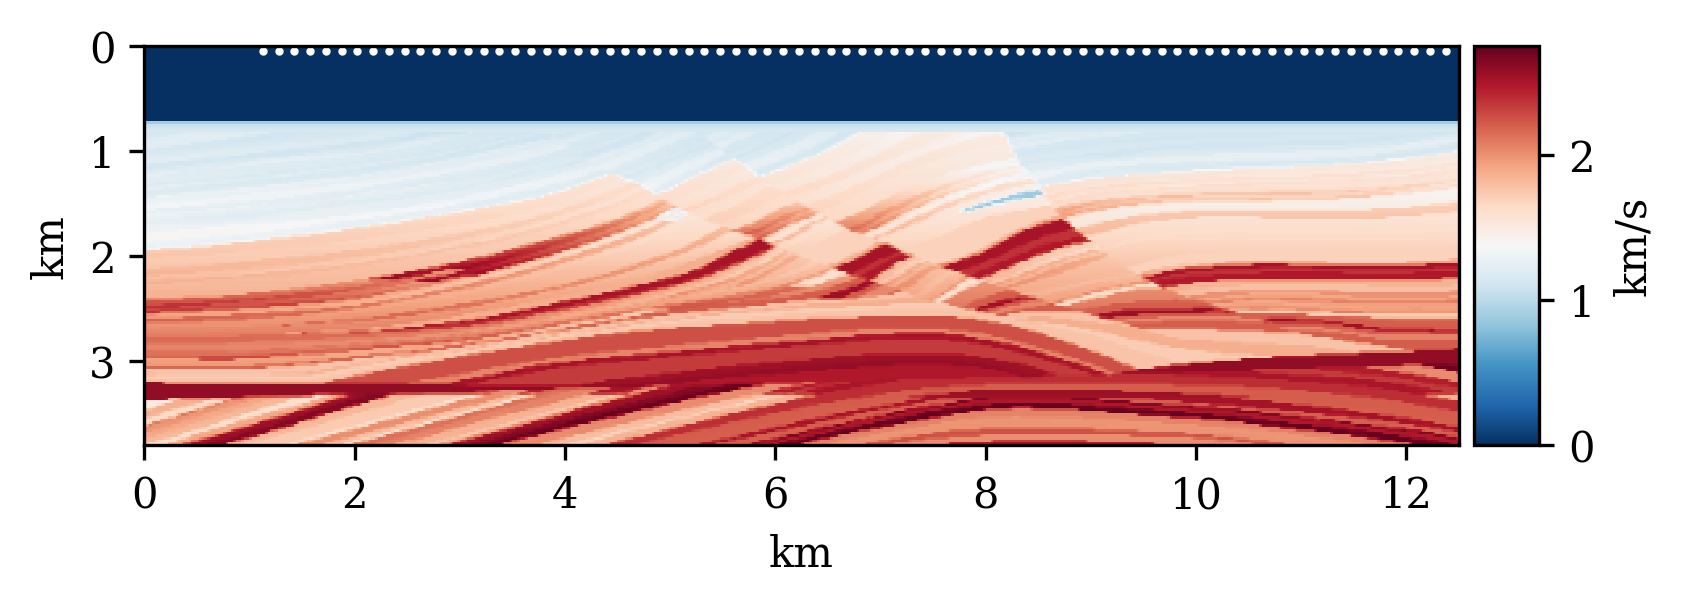

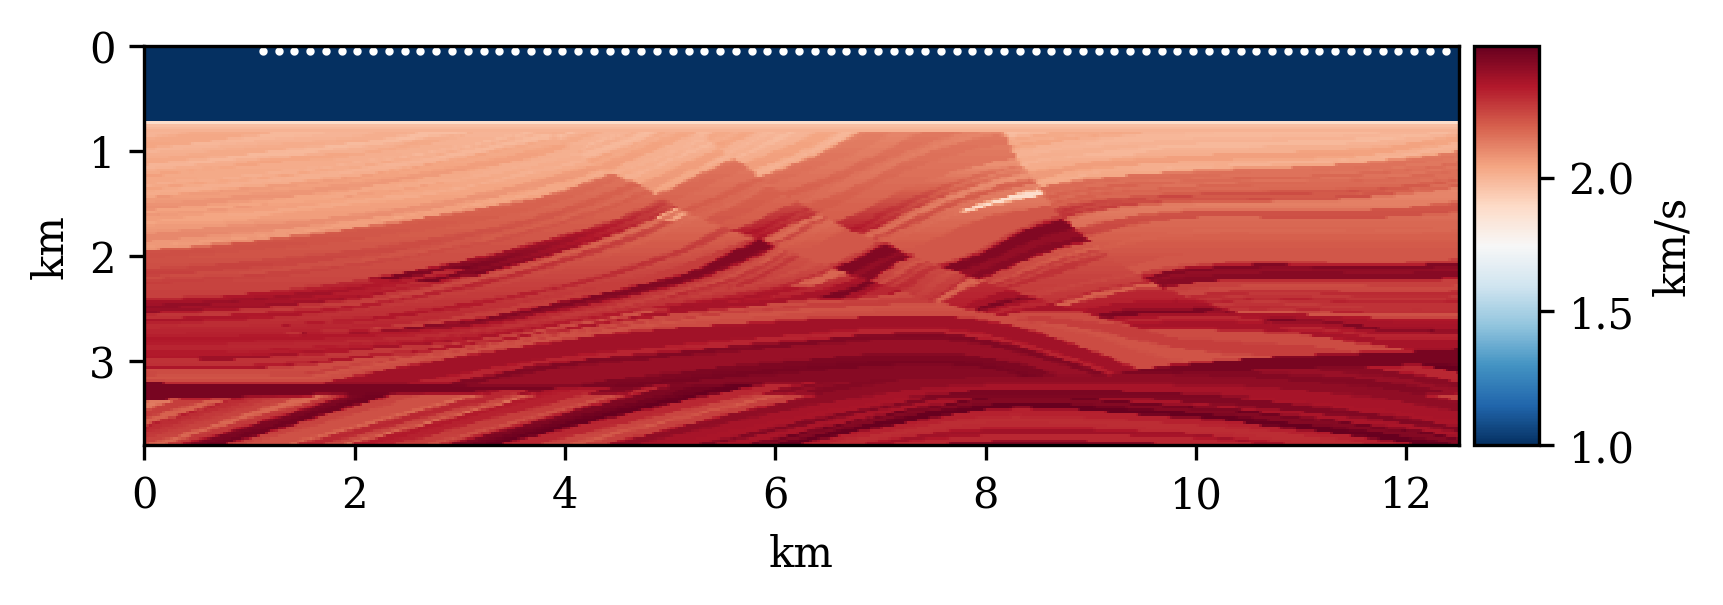

In [33]:
mpl.rcParams['figure.dpi']= 300
vis.plot_log_model(model.vp, dx, nx0, nz0, src, **limits_vp)
vis.plot_log_model(model.vs, dx, nx0, nz0, src, **limits_vs)
vis.plot_log_model(model.rho, dx, nx0, nz0, src, **limits_rho)
mpl.rcParams['figure.dpi']= 100

## Stages of inversion
Use default parameters, except high- and low-pass corner frequencies of Butterworth filter

In [34]:
par_stages_fwi = {'inv_vs_iter': 0,
                 'inv_rho_iter': 0,
                 'normalize': 2,
                 'order': 6,
                 }

# d.fwi_stages = []
# freqs_high = [3, 4, 5, 6, 7, 8]
# grad_smoothing = [2, 1.5, 1.0, 0.5, 0.25, 0.125]
# spatfilters = [4, 4, 0, 0, 0, 0]

freqs_high = [7,8,9,10]
grad_smoothing = [4, 3,2,0.0]
spatfilters = [4, 4, 4,0]
for i, freq in enumerate(freqs_high):
    d.add_fwi_stage(fc_high=freq, 
                    wd_damp=grad_smoothing[i],
                    wd_damp1=grad_smoothing[i],
                    spatfilter=spatfilters[i],
                    **par_stages_fwi)
    print(f'Stage {i+1}:\n\t{d.fwi_stages[i]}\n')

Stage 1:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 7, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 4, 'WD_DAMP': 4, 'WD_DAMP1': 4, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 2, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 2:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 8, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 4, 'WD_DAMP': 3, 'WD_DAMP1': 3, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 2, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 3:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 9, 'ORDER': 6, 'TIME_WIN': 0, 

In [35]:
d.SWS_TAPER_GRAD_HOR = 1
d.GRADT1, d.GRADT2 = 25, 30
print(model)
print(np.max(model.vp))

vp:	(152, 944), 1490.0000, 4766.6040 m/s

vs:	(152, 944), 0.0000, 2752.0001 m/s

rho:	(152, 944), 1000.0000, 2492.7201 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m
4766.60400390625


(152, 944) (152, 944)
Save (944, 152) as binary to ./out_for_pasha_marm_high_freqs/fld/taper/taper.bin
Save (944, 152) as binary to ./out_for_pasha_marm_high_freqs/fld/taper/taper_u.bin
Save (944, 152) as binary to ./out_for_pasha_marm_high_freqs/fld/taper/taper_rho.bin


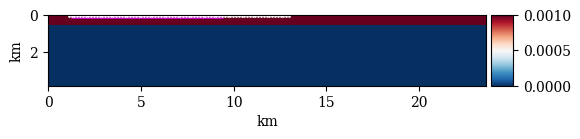

In [36]:
# import loaders as ld
# # Gradient tapering
# d.SWS_TAPER_GRAD_VERT = 0
# d.SWS_TAPER_GRAD_HOR = 0
# d.SWS_TAPER_CIRCULAR_PER_SHOT = 0   # enable grad tapering around sources

d.VPUPPERLIM = np.max(model.vp)
d.VPLOWERLIM = 1490
d.VSUPPERLIM = np.max(model.vs)
d.VSLOWERLIM = 0
d.RHOUPPERLIM = np.max(model.rho)
d.RHOLOWERLIM = 1000

d.SWS_TAPER_FILE = 1

taper = np.zeros_like(model_init.vp)
print(taper.shape,wb_taper.shape)
shift = 4
shift = 8
taper[shift:, :] = wb_taper[:-shift,:] # water mask
# taper[-nwater:, :] = 1.
# taper[-28:, :] = 1.
# taper[:, 650:] = 1.
# taper[:,-10:] = 1. # right
# taper[:,:10] = 1. # left
# taper[:5,:] = 1. # bottom
# nwater= 30 - shift
# taper[-nwater:, :] = 1.

# plt.imshow(taper)
if d.SWS_TAPER_FILE:
    os.makedirs(d._root_tapers, exist_ok=True)
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_u.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_rho.bin'))
    vis.plot_acquisition(taper, dx, src, rec)

In [37]:
field_data_dir=os.path.join(d.save_folder,'su','field')
d.pictures_folder=os.path.join(d.save_folder,'pictures');   os.makedirs(d.pictures_folder,exist_ok=True)
fmax=15
filter_seismograms=0
if filter_seismograms==1:
    import F_fwi as f_fwi
    d.verbose=0
    # print(f_fwi.bandpass)
    # field_data_dir='./out_for_pasha_marm/su/field/'
    filenames=d._get_filenames(field_data_dir)
    shots=d._from_su(filenames)
    print(filenames)
    print(shots[0].shape)
    dt=d.DT;    print(dt)
    corner_frequency=5
    corner_frequency=8
    print('low frequency data corner frequency, ',corner_frequency)
    fmax=10     # xlim in spectrum plotting
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    counter=0
    for shot,filename in zip(shots,filenames):
        ################    processing stage 1
        filtered_shot=f_fwi.bandpass(shot,fhi=6, dt=dt,order=8, btype='low')
        ################    processing stage 2
        filtered_shot2=f_fwi.bandpass(shot,flo=corner_frequency+0.2,dt=dt,order=8,btype='high')
        filtered_shot2_=bandpass(shot,flo=corner_frequency,fhi=6,dt=dt,order=8,btype='band') #for plotting purposes
        ################    processing stage 3
        filtered_shot3=zero_below_freq(filtered_shot2,corner_frequency,dt, disable=False,reverse=False)
        # filtered_shot3=zero_below_freq(shot,corner_frequency,dt, disable=False,reverse=False)
        filtered_shot3_=zero_below_freq(filtered_shot2_,corner_frequency,dt, disable=False,reverse=False)
        ################    chosen processing    
        filtered_shot_=filtered_shot3
        ################
        plotting_flag=1
        if plotting_flag==1:
            if counter==44:
                print('d.pictures_folder',d.pictures_folder)
                plot_shot(shot,pclip=0.05,folder_path=d.pictures_folder,file_path='shot.png',show=0)
                plot_shot(filtered_shot, pclip=0.05,folder_path=d.pictures_folder,file_path='shot_stage1.png',show=0)
                plot_shot(filtered_shot2,pclip=0.05,folder_path=d.pictures_folder,file_path='shot_stage2.png',show=0)
                plot_shot(filtered_shot2_,pclip=0.05,folder_path=d.pictures_folder,file_path='shot_stage2_precise.png',show=0)
                plot_shot(filtered_shot3,pclip=0.05,folder_path=d.pictures_folder,file_path='shot_stage3.png',show=0)
                plot_shot(filtered_shot3_,pclip=0.05,folder_path=d.pictures_folder,file_path='shot_stage3_precise.png',show=0)
                ###############
                freqs,ps=plot_spectrum(shot,d.DT,fmax=fmax,folder_path=           d.pictures_folder,file_path='spectrum_stage0.png')
                freqs,ps=plot_spectrum(filtered_shot,d.DT,fmax=fmax,folder_path=  d.pictures_folder,file_path='spectrum_stage1.png')
                freqs,ps=plot_spectrum(filtered_shot2,d.DT,fmax=fmax,folder_path= d.pictures_folder,file_path='spectrum_stage2.png')
                freqs,ps=plot_spectrum(filtered_shot2_,d.DT,fmax=fmax,folder_path=d.pictures_folder,file_path='spectrum_stage2_.png')
                freqs,ps=plot_spectrum(filtered_shot3,d.DT,fmax=fmax,folder_path= d.pictures_folder,file_path='spectrum_stage3.png')
                freqs,ps=plot_spectrum(filtered_shot3_,d.DT,fmax=fmax,folder_path=d.pictures_folder,file_path='spectrum_stage3_.png')
        ################    rewrite segy
        counter=counter+1
        print('rewriting ',filename)
        with segyio.su.open(filename,"r+",endian='little',ignore_geometry=True) as dst:
            dst.trace=filtered_shot_

In [38]:
#%% capture
print(field_data_dir)
filenames=d._get_filenames(field_data_dir)
shots2=d._from_su(filenames)
print(filenames)
print(shots2[0].shape)
counter=0
for shot,filename in zip(shots,filenames):
    plotting_flag=1
    if plotting_flag==1:
        if counter==44:
            plot_shot(shot,pclip=0.05,folder_path=d.pictures_folder,file_path='read_shot.png',show=0)
            freqs,ps=plot_spectrum(shot,d.DT,fmax=fmax,folder_path=d.pictures_folder,file_path='read_spectrum.png')
    ################    rewrite segy
    counter=counter+1
    print('rewriting ',filename)

./out_for_pasha_marm_high_freqs/fld/su/field
['./out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot1', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot2', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot3', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot4', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot5', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot6', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot7', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot8', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot9', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot10', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot11', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot12', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot13', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot14', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.

## Run inversion

In [39]:
d.DATA_DIR = f'{root_fwi}/su/field/seis'
print(f'Target data: {d.DATA_DIR}')

Target data: ./out_for_pasha_marm_high_freqs/fld/su/field/seis


In [40]:
d.WRITE_STF = 0
d.NPROCX = 8
d.NPROCY = 2
d.verbose = 1
par_fwi_runtime = {'run_command': 'mpirun -np 32', 'disable': True}

In [41]:
d.INV_MOD_OUT=1
d.MFILE=os.path.join(d.save_folder,'start/model_init'); print(d.MFILE)
d.filename=os.path.join(d.save_folder,'seis_inversion.inp');
d.fwi(model_init, src, rec, **par_fwi_runtime)

./out_for_pasha_marm_high_freqs/fld/start/model_init
Target data: ./out_for_pasha_marm_high_freqs/fld/su/field/seis
Create FWI workflow file in ./out_for_pasha_marm_high_freqs/fld/seis_fwi.inp
Init model:
	152 x 944, dx = 25.0 m
Check max source frequency:
	min Vs: 901.2389183973957 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.769527570703476 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 944 % 8 = 0
	in Y-direction, NY % NPROCY, 152 % 2 = 0
Write ./out_for_pasha_marm_high_freqs/fld/start/model_init.vp
Write ./out_for_pasha_marm_high_freqs/fld/start/model_init.vs
Write ./out_for_pasha_marm_high_freqs/fld/start/model_init.rho
Custom taper from taper.bin (vp), taper_u.bin (vs) and taper_rho.bin (rho)
Enable streamer mode!
	source 1: ./out_for_pasha_marm_high_freqs/fld/receiver/receivers_shot_1
	source 2: ./out_for_pasha_marm_high_freqs/fld/receiver/receivers_shot_2
	source 3: ./out_for_

In [42]:
sbatch_file_name=simulation_root.split('/')[-1]+'.sh'
print(sbatch_file_name)
create_sbatch_file_for_fwi_folder(sbatch_file_name,simulation_root)

out_for_pasha_marm_high_freqs.sh
out_for_pasha_marm_high_freqs.sh
./out_for_pasha_marm_high_freqs/post_processing_script.py


### Visualize FWI outputs
It will not hurt to make sure that paths and model dims are up to date. This is necessary when you only want to plot pictures, without running modeling or FWI

In [43]:
d.set_model(model_init)
print(d.save_folder)

Init model:
	152 x 944, dx = 25.0 m
./out_for_pasha_marm_high_freqs/fld


### Inverted model
The code ouputs inverted models for every elastic property at every FWI stage. Change `vp` to `vs` or `rho` to explore respective outputs

In [44]:
mpl.rcParams['figure.dpi']= 300
d.verbose = 2

models, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
for m, f in zip(models, fnames):
    vis.plot_log_model(m, dx, nx0, nz0, src, log=log / 2, log_location=log_location, **limits_vp)
mpl.rcParams['figure.dpi']= 100

Parse files from ./out_for_pasha_marm_high_freqs/fld/model which contain ['vp', 'stage']
No files found! Exception raised.


### Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

In [45]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    plot_logs(model, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

Parse files from ./out_for_pasha_marm_high_freqs/fld/model which contain ['vp_stage']
No files found! Exception raised.
Parse files from ./out_for_pasha_marm_high_freqs/fld/model which contain ['vs_stage']
No files found! Exception raised.
Parse files from ./out_for_pasha_marm_high_freqs/fld/model which contain ['rho_stage']
No files found! Exception raised.


### Gradients

In [46]:
d.verbose = 0
grads, fnames = d.get_fwi_gradients(return_filenames=True)
for g, f in zip(grads, fnames):
    plot_model(g, f)

In [47]:
print(d.save_folder)
d.pictures_folder=os.path.join(d.save_folder,'pictures');   os.makedirs(d.pictures_folder,exist_ok=True)
d.verbose=0
print(d._root_su)

field_data_dir=os.path.join(d.save_folder,'su/field/')
filenames=d._get_filenames(field_data_dir)
shots=d._from_su(filenames)
print(filenames)
print(shots[0].shape)
if shots!=[]:
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    it_list=[int(np.floor(x)) for x in np.linspace(0,len(shots)-1)]
    it_list=np.arange(0,len(shots)-1,int(len(shots)/3)).tolist()
    # it_list=[0]
    for i in it_list:
        # filtered_shot=bandpass(shot[i],flo=corner_frequency,dt=dt,order=8,btype='high')
        filtered_shot=bandpass(shots[i],fhi=6,dt=d.DT,order=8,btype='low')
        freqs,ps=plot_spectrum(shots[i],d.DT,fmax=10,folder_path=d.pictures_folder,file_path='spectrum_shots_'+str(i)+'.png')
        plot_shot(shots[i], pclip=0.05, title=str(i),folder_path=d.pictures_folder,file_path='shot'+str(i)+'.png',show=0)
        freqs,ps=plot_spectrum(filtered_shot,d.DT, fmax=10,folder_path=d.pictures_folder,file_path='spectrum_low_freq_precisely_shots_'+str(i)+'.png')
        plot_shot(filtered_shot,pclip=0.05, title=str(i),folder_path=d.pictures_folder,file_path='shot_low_freq_precisely_'+str(i)+'.png',show=0)

./out_for_pasha_marm_high_freqs/fld
./out_for_pasha_marm_high_freqs/fld/su
['./out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot1', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot2', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot3', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot4', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot5', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot6', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot7', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot8', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot9', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot10', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot11', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot12', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot13', './out_for_pasha_marm_high_freqs/fld/su/field/seis_p.su.shot14', './out_for_pasha_marm_h

In [48]:
# denise_folder_process('plotting',d.save_folder)
# print(d.help())
print(d.save_folder.split('/fld')[0])
# denise_plotting2(d,d.save_folder.split('/fld')[0],pars=None)
comps=['vp']
vplim = {'vmax': 1500, 'vmin': 4500}
vslim = {'vmax': 1000, 'vmin': 4000}
rholim={'vmax': 0, 'vmin': 4000}
dv_lim={'vmax': 500, 'vmin': -500}
vlims = {'vp': vplim, 'vs': vslim,'rho': rholim,'dv': dv_lim}
if os.path.exists((os.path.join(d.save_folder,'model'))):
    if len(os.listdir(os.path.join(d.save_folder,'model')))>0:
        models,fnames = d.get_fwi_models(return_filenames=True,keys=comps)
        for m, f in zip(models, fnames):
            f_name=(f.split('/')[-1]).split('.')[0]
            # for component in ['vp']:    #,'vs','rho'
            for component in comps:    #,'vs','rho'
                if component in f_name: 
                    r2='_r2(m_i,true)_'+numstr3(F_r2(m,getattr(model,component)))
                    plot_acquisition(m,model,src,rec,f_name+r2,**vlims[component],folder_path=d.pictures_folder,file_path=f_name+r2+'.png')
                    plot_acquisition(m-getattr(model_init,component),model,src,rec,f_name+r2,folder_path=d.pictures_folder,file_path=f_name+'_dv(m_i,true)'+r2+'.png')
        models, fnames = d.get_fwi_tapers(return_filenames=True)
        for m, f in zip(models,fnames):
            f_name=(f.split('/')[-1]).split('.')[0]
            plot_acquisition(m,model,src,rec,f_name,folder_path=d.pictures_folder,file_path=f_name+'.png')

./out_for_pasha_marm_high_freqs


In [49]:
def get_model_last():
    d.verbose=1
    print(os.getcwd())
    all_fnames = []
    vps, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
    all_fnames += fnames
    vss, fnames = d.get_fwi_models(['vs', 'stage'], return_filenames=True)
    all_fnames += fnames
    rhos, fnames = d.get_fwi_models(['rho', 'stage'], return_filenames=True)
    all_fnames += fnames

    if all_fnames:
        for f in all_fnames:
            if not f.split('/')[-1] in os.listdir(f'{root_fwi}start/'):
                command = f'cp {f} {root_fwi}start/'
                print(command)
                os.system(command)

    if vps:
        print(f'Init new starting model from {fnames[-1]}')
        model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    return model_last

model_last = get_model_last()

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Read models from ./out_for_pasha_marm_high_freqs/fld/model with ['vp', 'stage']
Read models from ./out_for_pasha_marm_high_freqs/fld/model with ['vs', 'stage']
Read models from ./out_for_pasha_marm_high_freqs/fld/model with ['rho', 'stage']


UnboundLocalError: local variable 'model_last' referenced before assignment

# Compare wavefiedls before/after

In [ ]:
vps, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
vss, fnames = d.get_fwi_models(['vs_stage'], return_filenames=True)
rhos, fnames = d.get_fwi_models(['rho_stage'], return_filenames=True)

if vps:
    model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    print(f'Found last model at {fnames[-1]}')
else:
    print(f'Not found the inverted model in {d.save_folder}!')

In [ ]:
d.save_folder = root_fwi[:-1] + '_wavefield/'
print(f'{root_fwi[:-1]} --> {d.save_folder}')

In [ ]:
d.NPROCX = 1
d.NPROCY = 1
d.forward(model_last, src, rec, **par_forward)

In [ ]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]
print(f'Read {len(shots)} shots {shots[0].shape} into list')

for ishot in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 4)]:
    shot_s = divmax(shots[ishot])
    shot_f = divmax(data_p[ishot, :, ::d.NDT])
    vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.125)
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.125)